In [1]:
import numpy  as np
import pandas as pd
import tables as tb
import matplotlib.pyplot as plt

from ic_course_utils import replace_tag
from ic_course_utils import find_pmap_with_s1_s2

%matplotlib inline

In [2]:
input_file = "data/Kr83_fullsim.irene.h5"
#input_file = "data/Kr83_fastsim.irene.h5"
#input_file = "data/Kr83_fullsim.hypathia.h5"
#input_file = "data/Kr83_fastsim.hypathia.h5"

# Input file structure

The input file contains five nodes under the group `/PMAPS/`:
- `/PMAPS/S1`: holds the PMT-summed waveform slices of S1 signals
- `/PMAPS/S1Pmt`: holds the individual PMT waveform slices of S1 signals
- `/PMAPS/S2`: holds the PMT-summed waveform slices of S2 signals
- `/PMAPS/S2Pmt`: holds the individual PMT waveform slices of S2 signals
- `/PMAPS/S2Si`: holds the individual SiPM waveform slices of S2 signals

These are tables with the following columns.
- For `S1`and `S2`: event, peak number, waveform time, bin width and amplitude (of the PMT-summed waveform)
- For `S1Pmt`and `S2Pmt` and `S2Sipm`: event, peak number, sensor id and amplitude (of the individual sensor waveform)

`/PMAPS/S1Pmt` and `/PMAPS/S2Pmt` are not used in the default reconstruction chain.

In [3]:
!ptdump -v $input_file:/PMAPS

/PMAPS (Group) ''
/PMAPS/S1 (Table(73,)shuffle, zlib(4)) 'S1 Table'
  description := {
  "event": Int64Col(shape=(), dflt=0, pos=0),
  "peak": UInt8Col(shape=(), dflt=0, pos=1),
  "time": Float32Col(shape=(), dflt=0.0, pos=2),
  "bwidth": Float32Col(shape=(), dflt=0.0, pos=3),
  "ene": Float32Col(shape=(), dflt=0.0, pos=4)}
  byteorder := 'little'
  chunkshape := (3120,)
  autoindex := True
  colindexes := {
    "event": Index(6, mediumshuffle, zlib(1)).is_csi=False}
/PMAPS/S1Pmt (Table(876,)shuffle, zlib(4)) 'S1Pmt Table'
  description := {
  "event": Int64Col(shape=(), dflt=0, pos=0),
  "peak": UInt8Col(shape=(), dflt=0, pos=1),
  "npmt": UInt8Col(shape=(), dflt=0, pos=2),
  "ene": Float32Col(shape=(), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (4681,)
  autoindex := True
  colindexes := {
    "event": Index(6, mediumshuffle, zlib(1)).is_csi=False}
/PMAPS/S2 (Table(110,)shuffle, zlib(4)) 'S2 Table'
  description := {
  "event": Int64Col(shape=(), dflt=0, pos=0),
  "pea

# Input file data visualization

PMaps have a friendly human interface in IC.
The `Pmap` class is a collection of S1 and S2 `Peak`s:
```
pmap.s1s = [s1_signal_1, s1_signal_2, ...]
pmap.s2s = [s2_signal_1, s2_signal_2, ...]
```
Each `Peak` aggregates 3 objects:
- times: an array of the times corresponding to each waveform sample
- pmts: a SensorResponse object containing the PMT data
- sipms: a SensorResponse object containing the SiPM data

Each `SensorResponse` contains the following information:
- `ids`: the id numbers of the sensors stored in this object
- `all_waveforms`: the waveform slices corresponding to the `times` stored in `Peak`

`Peak` and `SensorResponse` contain several attributes and methods that implement the most common operations on PMaps.

PMaps can be also read as pandas DataFrames.

In [4]:
from invisible_cities.io.pmaps_io import load_pmaps
from invisible_cities.io.pmaps_io import load_pmaps_as_df

pmaps    = load_pmaps      (input_file)
pmaps_df = load_pmaps_as_df(input_file)

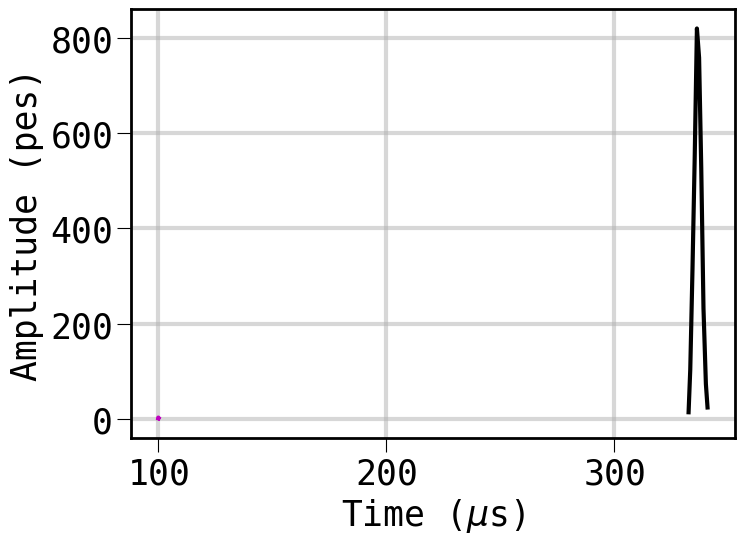

In [5]:
event_number, pmap = find_pmap_with_s1_s2(pmaps)
pmap = pmaps[event_number]
for s1 in pmap.s1s: # s1 is a `Peak`
    plt.plot(s1.times / 1e3, s1.pmts.sum_over_sensors, "m") # plot the PMT-summed waveform slice

for s2 in pmap.s2s: # s2 is a `Peak`
    plt.plot(s2.times / 1e3, s2.pmts.sum_over_sensors, "k") # plot the PMT-summed waveform slice
    
plt.xlabel("Time ($\mu$s)")
plt.ylabel("Amplitude (pes)");

Some common operations on PMaps (explore the classes in https://github.com/next-exp/IC/blob/master/invisible_cities/evm/pmaps.py for more details):

In [6]:
s1 = pmap.s1s[0]
s2 = pmap.s2s[0]
print(f"The PMT integral of the S2 is {s2.total_energy:.1f} pes")
print(f"The SiPM integral of the S2 is {s2.total_charge:.1f} pes")
print(f"The width of the S2 is {s2.width/1e3:.1f} us")
print(f"The height of the S2 is {s2.height:.1f} pes")
print(f"The S1 of this event happened at {s1.time_at_max_energy/1e3:.2f} us")

The PMT integral of the S2 is 3411.7 pes
The SiPM integral of the S2 is 36.8 pes
The width of the S2 is 8.7 us
The height of the S2 is 820.9 pes
The S1 of this event happened at 100.10 us


The same can be achieved with DataFrames:

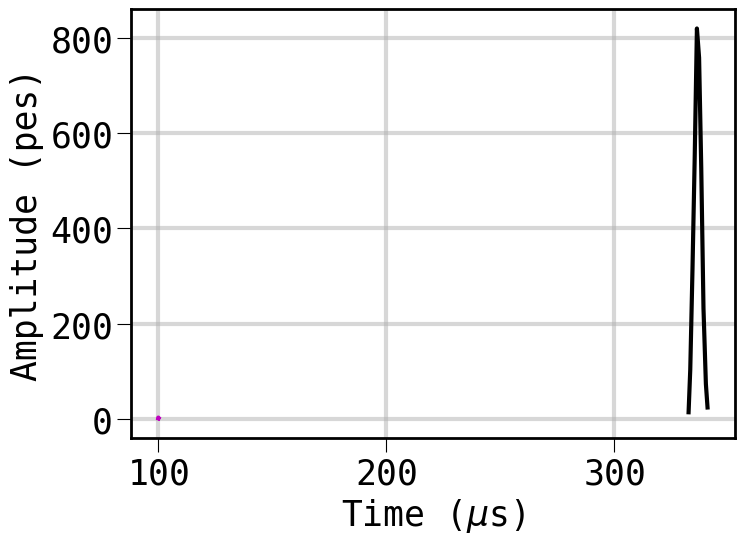

In [7]:
event_number, pmap = find_pmap_with_s1_s2(pmaps)
s1s, s2s, s2sis, s1pmts, s2pmts = pmaps_df
s1s   = s1s  .loc[lambda df: df.event == event_number]
s2s   = s2s  .loc[lambda df: df.event == event_number]
s2sis = s2sis.loc[lambda df: df.event == event_number]

for _, s1 in s1s.groupby("peak"):
    plt.plot(s1.time / 1e3, s1.ene, "m") # plot the PMT-summed waveform slice

for _, s2 in s2s.groupby("peak"):
    plt.plot(s2.time / 1e3, s2.ene, "k") # plot the PMT-summed waveform slice

plt.xlabel("Time ($\mu$s)")
plt.ylabel("Amplitude (pes)");

In [8]:
s1 = s1s  .loc[lambda df: df.peak == 0]
s2 = s2s  .loc[lambda df: df.peak == 0]
si = s2sis.loc[lambda df: df.peak == 0]

# need to add one bin for the total width!
dt = s2.time.max() - s2.time.min() + s2.bwidth.iloc[-1]

print(f"The PMT integral of the S2 is {s2.ene.sum():.1f} pes")
print(f"The SiPM integral of the S2 is {si.ene.sum():.1f} pes")
print(f"The width of the S2 is {dt/1e3:.1f} us")
print(f"The height of the S2 is {s2.ene.max():.1f} pes")
print(f"The S1 of this event happened at {s1.time.loc[s1.ene.idxmax()]/1e3:.2f} us")

The PMT integral of the S2 is 3411.7 pes
The SiPM integral of the S2 is 36.8 pes
The width of the S2 is 8.7 us
The height of the S2 is 820.9 pes
The S1 of this event happened at 100.10 us


# Dorothea

## Description

Summarizes the S1 and S2 properties of an event treating them as pointlike energy depositions.

This city reads Peak Maps (a.k.a PMaps) produced by Irene or Hypathia and produces kDSTs.
Each combination of S1 and S2 signals is processed to produce reconstructed a location in 3D and several S1 and S2 properties.
For each S1-S2 pair, the city applies the following selection criteria on S1 and S2 peaks:
- Width
- Height
- Integral
- Number of SiPMs involved (S2 only)

These properties are measured based on thresholds applied to the PMT-summed waveform.
The event is then selected or discarded based on whether the number of selected S1 and S2 signals fall within the specified range.
Surviving events are processed to obtain the following event properties:
- Width      (width of the PMT waveform)
- Height     (height of the PMT waveform)
- Energy     (sum of the PMT waveform)
- (Max) time (buffer time at maximum waveform amplitude)
- Charge     (sum of the SiPM waveforms)
- Nsipm      (number of SiPMs with signal over threshold)
- X, Y       (reconstructed X,Y position from the SiPM pattern)
- DT         (delta between max S2 and S1 times)
- Z          (reconstructed Z position from DT/ drift velocity)
- Xrms       (standard dev. of the SiPM signal in the x coordinate)
- Yrms       (standard dev. of the SiPM signal in the y coordinate)
- Zrms       (standard dev. of the PMT  signal in the z coordinate)
- R          (radial coordinate from X and Y)
- Phi        (azimuthal coordinate from X and Y)

More details will be found in the official documentation:
https://next-exp-sw.readthedocs.io/en/latest/irene.html
. Currently this is under construction in
https://github.com/next-exp/sw-docs/pull/15

## Parameters

| Parameter | Type  | Description |
|:--------:|:--------:|:--------:|
| `drift_v` | `float | Estimated drift velocity |
| `s1_nmin, s1_nmax, s2_nmin, s2_nmax` | `int` | Limits to the number of selected S1 and S2 signals per event (both inclusive) |
| `s1_emin, s1_emax, s2_emin, s2_emax` | `float` | Limits to the energy of S1 and S2 signals in pes |
| `s1_wmin, s1_wmax, s2_wmin, s2_wmax` | `float` | Limits to the width of S1 and S2 signals |
| `s1_hmin, s1_hmax, s2_hmin, s2_hmax` | `float` | Limits to the height of S1 and S2 signals in pes |
| `s1_ethr, s2_ethr` | `float` | Threshold to apply to S1 and S2 signals for the calculation of other properties |
| `s2_nsipmmin, s2_nsipmmax` | `int` | Limits to the number of SiPMs involved in an S2 signal (both inclusive) |
| `global_reco_algo` | `XYReco` | Which algorithm to use for event reconstruction: barycenter (most commonly used) or corona |
| `global_reco_params` | `dict` | Parameters to configure the reconstruction algorithm |
| `sipm_charge_type` | `SiPMCharge` | How to treat SiPM signals: raw (most commonly used) or signal_to_noise |
| `include_mc` | `Optional[bool]` | Whether to include MC tables in the output file (defaults to False) |

## Configuration

A typical Dorothea configuration file for NEW data.

Note that here we don't specify the input and output files in the config file, but you can do so!

In [9]:
config_file = "config_files/dorothea.conf"

In [10]:
!cat $config_file

event_range = all
compression = "ZLIB4"
print_mod   = 1

detector_db = "new"
run_number = -6400

drift_v     =      1    * mm / mus
s1_nmin     =      1
s1_nmax     =      1
s1_emin     =      0    * pes
s1_emax     =     30    * pes
s1_wmin     =    100    * ns
s1_wmax     =    500    * ns
s1_hmin     =      0    * pes
s1_hmax     =     10    * pes
s1_ethr     =      0.37 * pes
s2_nmin     =      1
s2_nmax     =      2
s2_emin     =    1e3    * pes
s2_emax     =    1e8    * pes
s2_wmin     =      1    * mus
s2_wmax     =     20    * mus
s2_hmin     =    500    * pes
s2_hmax     =    1e5    * pes
s2_ethr     =      1    * pes
s2_nsipmmin =      2
s2_nsipmmax =   1000

global_reco_algo   = barycenter
global_reco_params = dict(
  Qthr =  1 * pes
)

sipm_charge_type = raw

## City execution

In [11]:
output_file = replace_tag(input_file, "hypathia irene", "dorothea")
output_file

'data/Kr83_fullsim.dorothea.h5'

In [12]:
!city dorothea $config_file -i $input_file -o $output_file

NumExpr defaulting to 4 threads.
Using selector: EpollSelector
events processed: 0, event number: 0
events processed: 1, event number: 13
events processed: 2, event number: 26
events processed: 3, event number: 39
events processed: 4, event number: 52
events processed: 5, event number: 65
events processed: 6, event number: 78
events processed: 7, event number: 91
events processed: 8, event number: 104
events processed: 9, event number: 117


## Output

kDST: a table containing the properties of each S1-S2 combination of an event.
Each row contains a S1-S2 pair in an event. The data is stored in a single node `/DST/Events`.

The table contains the following columns:
- event: event number
- time: timestamp of the event in s
- s1_peak, s2_peak: index of the S1/S2 peak within the event
- nS1, nS2: number of selected S1s/S2s in the event
- S1w, S2w: width of the S1/S2 signal in ns/mus
- S1h, S2h: height of the S1/S2 signal in pes
- S1e, S2e: integral of the PMT peak for S1/S2 signals in pes
- S1t, S2t: time at the maximum amplitude of the S1/S2 signal in ns
- S2q: integral of the SiPM signal (for S2 peaks) in pes
- qmax: maximum SiPM charge in pes
- Nsipm: number of sipms with signal
- DT: difference between S2t and S1t in mus
- Z: drift distance in mm
- X, Y: reconstructed x-y position
- Xrms, Yrms: standard deviation of the SiPM signal in x/y
- Zrms: standard deviation of the PMT signal in the z coordinate
- R: transverse distance to the center of the chamber
- Phi: azimuthal angle

In [13]:
!ptdump -v $output_file:/DST/Events

/DST/Events (Table(5,)shuffle, zlib(4)) 'KDST Events'
  description := {
  "event": Int64Col(shape=(), dflt=0, pos=0),
  "time": Float64Col(shape=(), dflt=0.0, pos=1),
  "s1_peak": UInt16Col(shape=(), dflt=0, pos=2),
  "s2_peak": UInt16Col(shape=(), dflt=0, pos=3),
  "nS1": UInt16Col(shape=(), dflt=0, pos=4),
  "nS2": UInt16Col(shape=(), dflt=0, pos=5),
  "S1w": Float64Col(shape=(), dflt=0.0, pos=6),
  "S1h": Float64Col(shape=(), dflt=0.0, pos=7),
  "S1e": Float64Col(shape=(), dflt=0.0, pos=8),
  "S1t": Float64Col(shape=(), dflt=0.0, pos=9),
  "S2w": Float64Col(shape=(), dflt=0.0, pos=10),
  "S2h": Float64Col(shape=(), dflt=0.0, pos=11),
  "S2e": Float64Col(shape=(), dflt=0.0, pos=12),
  "S2q": Float64Col(shape=(), dflt=0.0, pos=13),
  "S2t": Float64Col(shape=(), dflt=0.0, pos=14),
  "qmax": Float64Col(shape=(), dflt=0.0, pos=15),
  "Nsipm": UInt16Col(shape=(), dflt=0, pos=16),
  "DT": Float64Col(shape=(), dflt=0.0, pos=17),
  "Z": Float64Col(shape=(), dflt=0.0, pos=18),
  "Zrms": Floa

kDSTs are read directly as pandas DataFrames:

In [14]:
dst = pd.read_hdf(output_file, "/DST/Events")
dst

,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,S1t,...,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
0,0,663917.794,0,0,1,1,175.0,2.040691,8.566140,100100.0,...,2,236.414474,236.414474,1.572906,-35.000000,107.887244,113.422473,1.884497,0.000000,4.531695
1,13,771102.390,0,0,1,1,150.0,2.729223,10.976800,100150.0,...,3,115.331352,115.331352,1.167844,-32.433938,-166.350112,169.482507,-1.763355,4.367602,3.417355
2,78,4585816.273,0,0,1,1,250.0,2.546154,13.128656,100100.0,...,2,360.390778,360.390778,1.817693,-43.855241,-46.137362,63.654837,-2.330841,44.834553,129.522041
3,91,5053324.902,0,0,1,1,100.0,2.316074,7.320443,100100.0,...,3,290.367554,290.367554,1.693628,-101.055055,-63.343588,119.266652,-2.581684,4.887418,7.719526
4,117,6389427.919,0,0,1,1,150.0,1.481364,6.372027,100100.0,...,2,158.395767,158.395767,1.335221,115.000000,31.506827,119.237914,0.267411,0.000000,4.767544


kDSTs do not have a good display on an event-by-event basis, but they are useful to measure statistical properties of the dataset. For demonstration purposes we will use a different file from the one produced above.

In [15]:
dst_large = pd.read_hdf("data/Kr83_highstat.dorothea.h5", "/DST/Events")

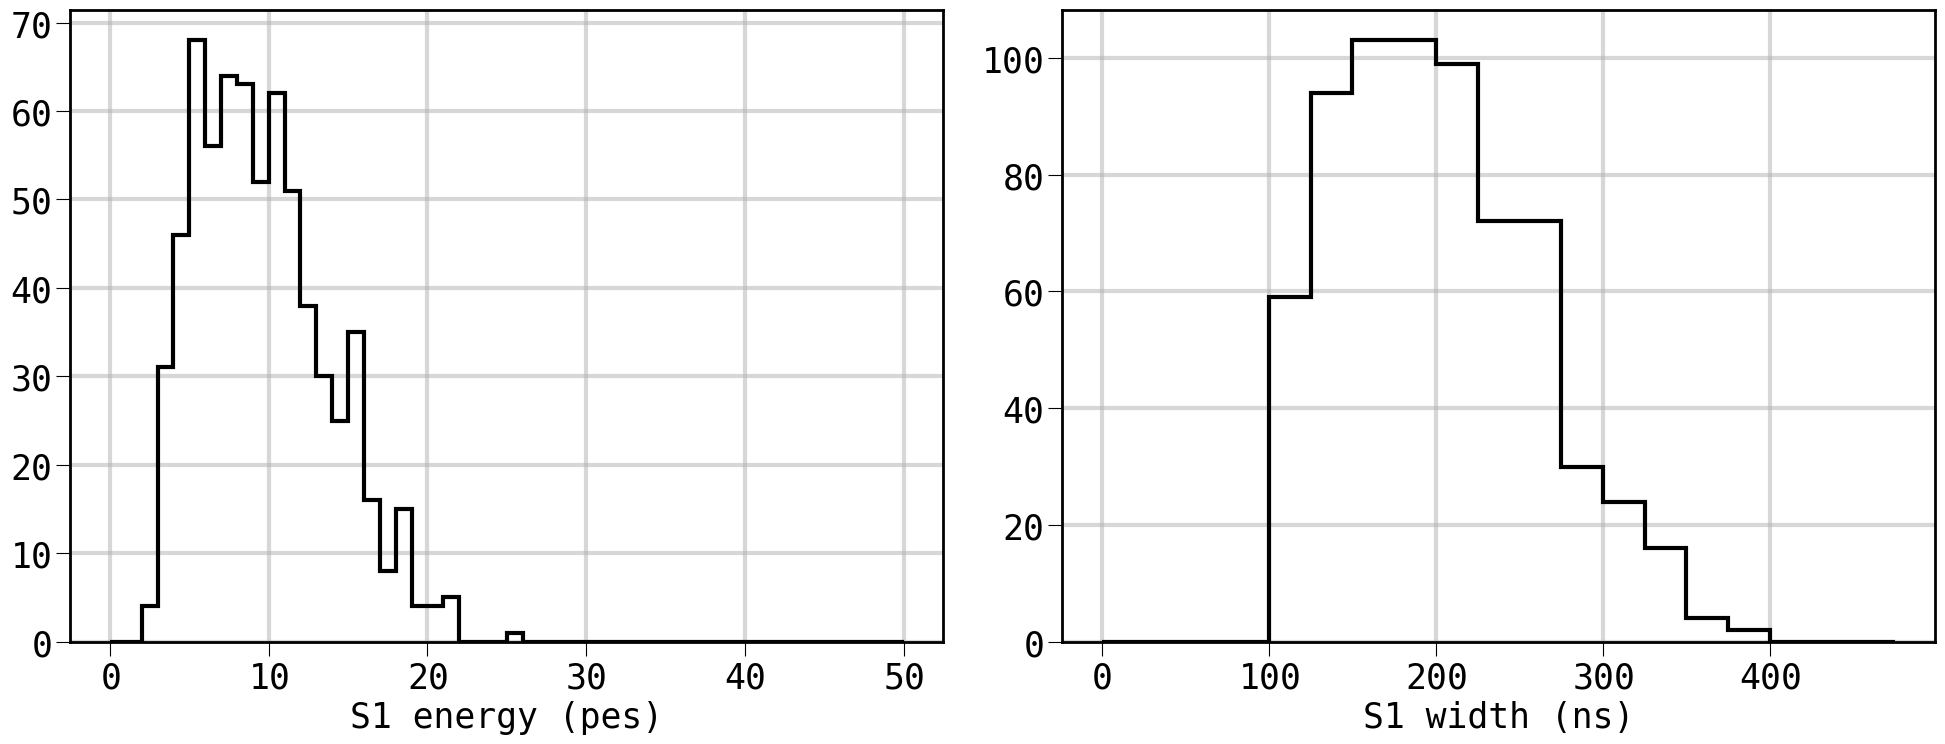

In [16]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1); plt.hist(dst_large.S1e, np.linspace(0,  50, 51), histtype="step"); plt.xlabel("S1 energy (pes)")
plt.subplot(1, 2, 2); plt.hist(dst_large.S1w, np.arange  (0, 500, 25), histtype="step"); plt.xlabel("S1 width (ns)")
plt.tight_layout()

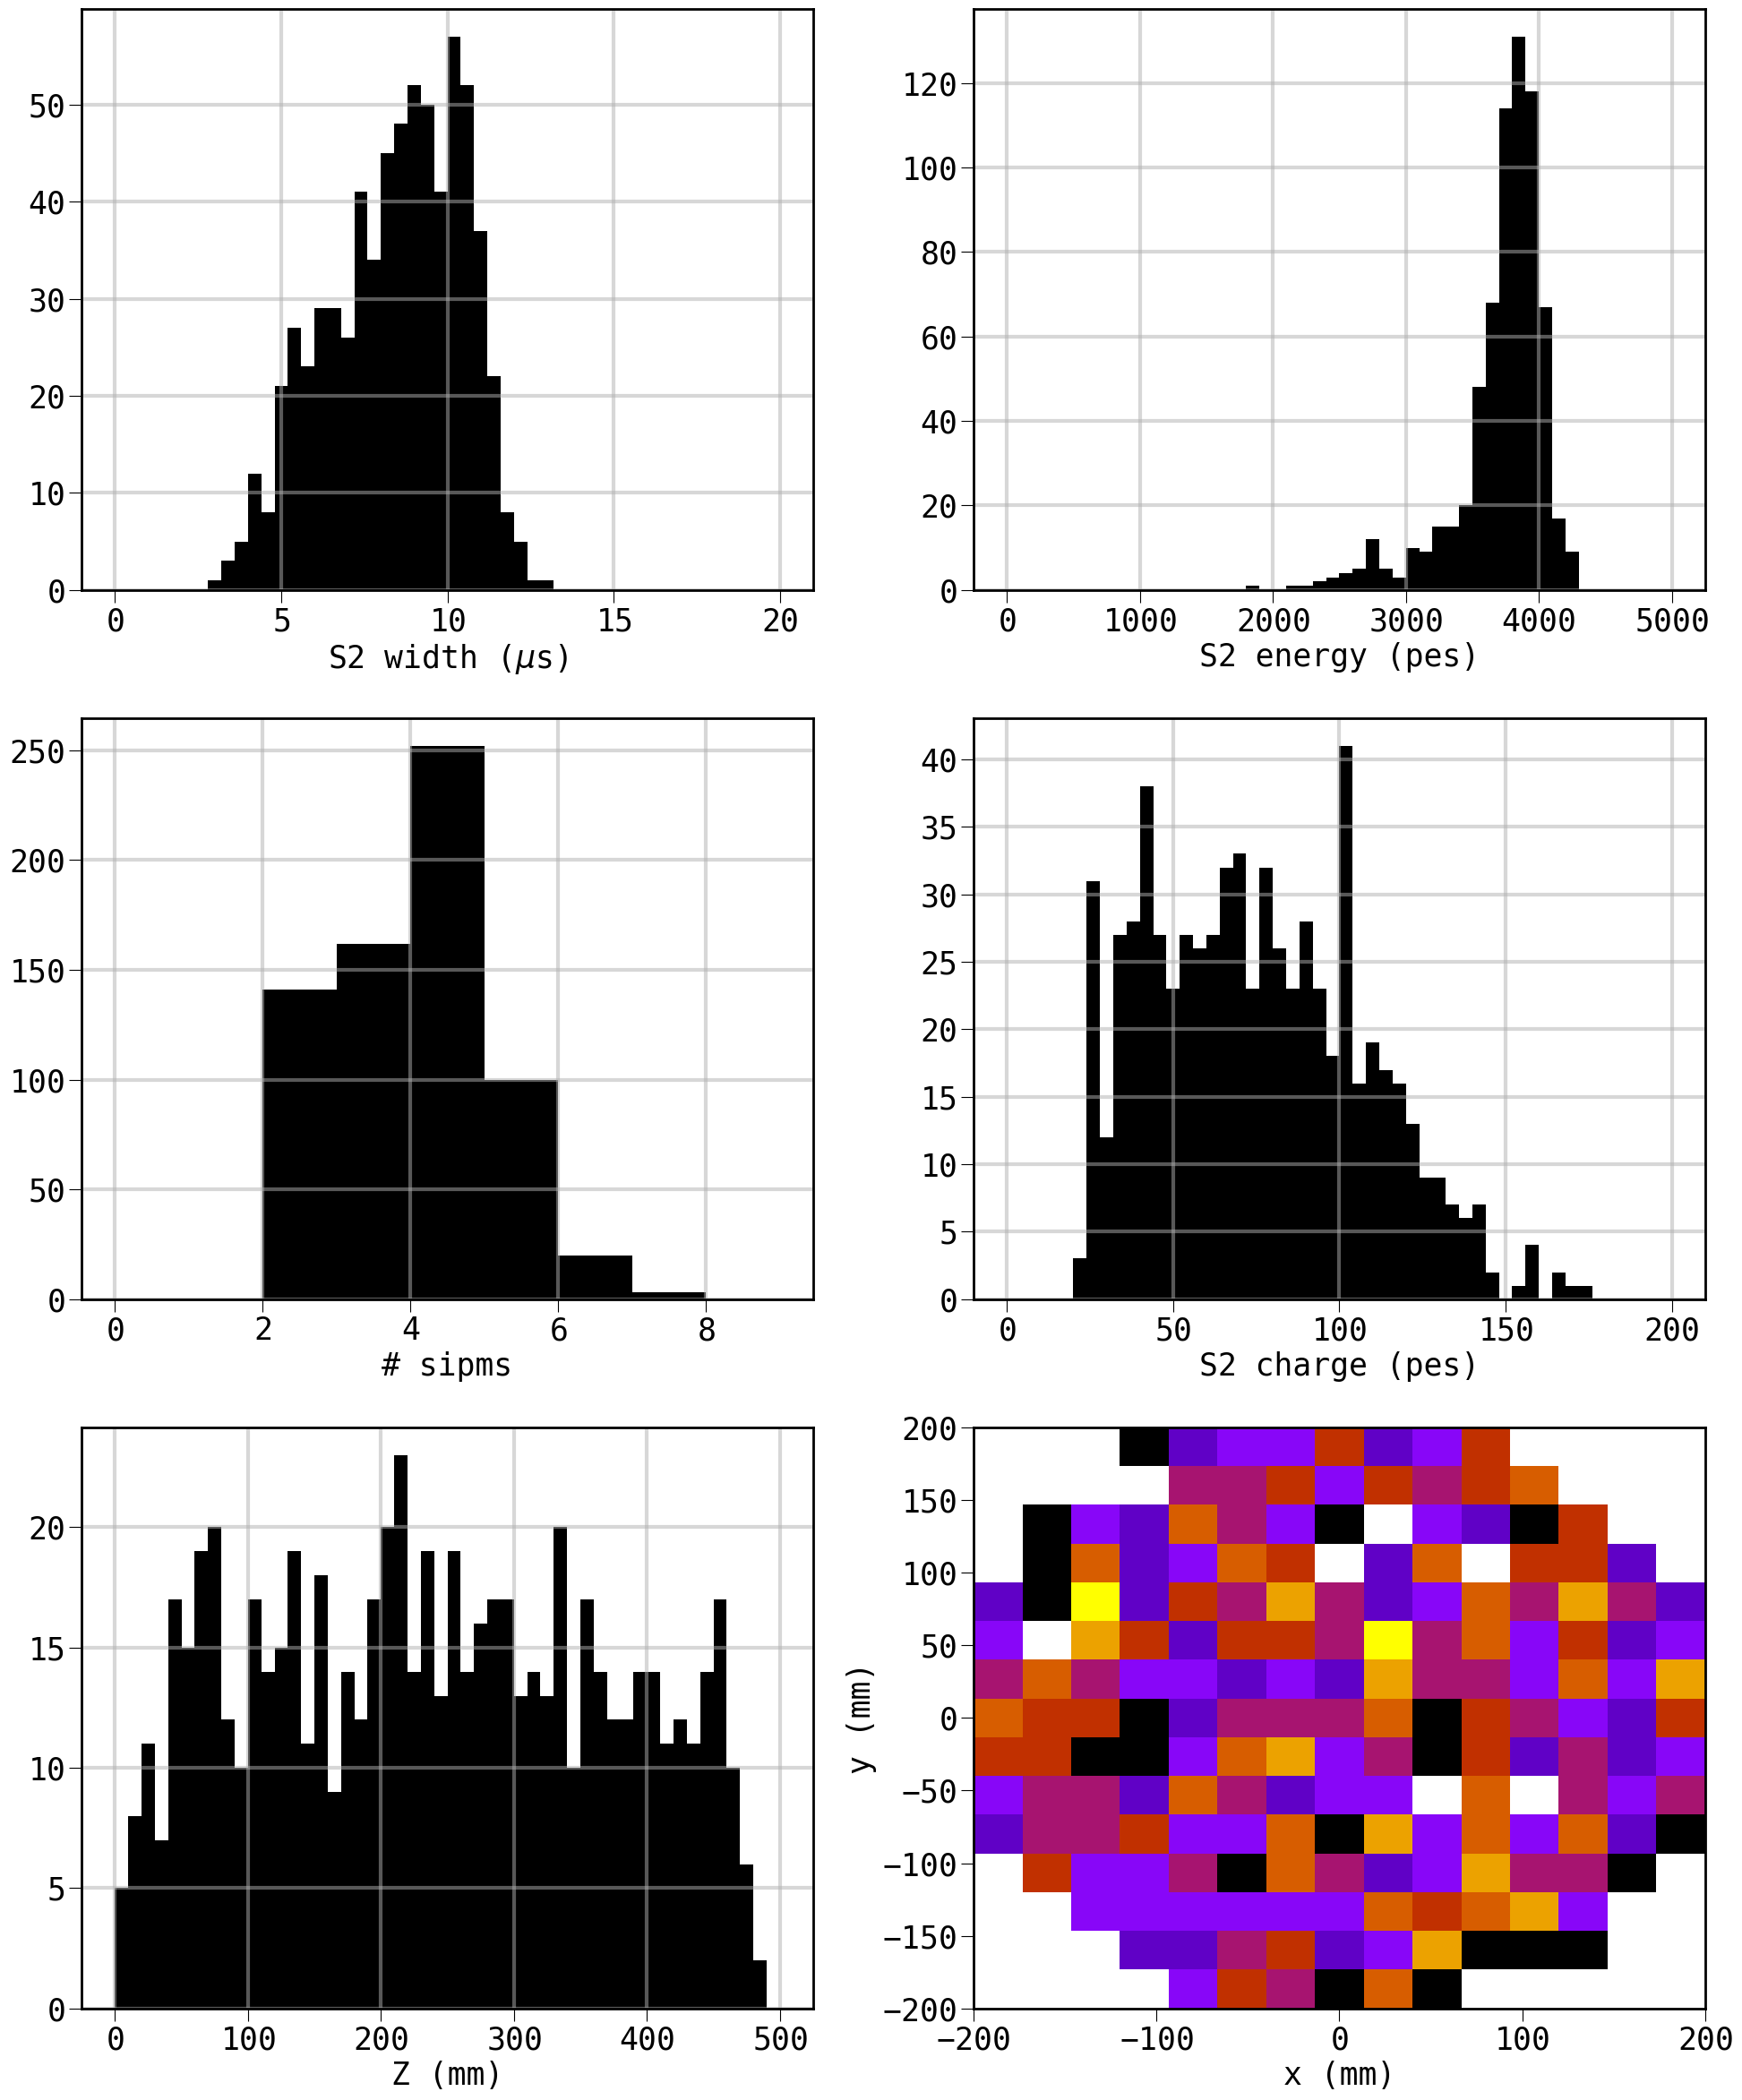

In [17]:
plt.figure(figsize=(20, 24))
plt.subplot(3, 2, 1); plt.hist(dst_large.S2w, np.linspace(0,  20, 51)); plt.xlabel("S2 width ($\mu$s)")
plt.subplot(3, 2, 2); plt.hist(dst_large.S2e, np.linspace(0, 5e3, 51)); plt.xlabel("S2 energy (pes)")
plt.subplot(3, 2, 3); plt.hist(dst_large.Nsipm, np.arange(0, 10)); plt.xlabel("# sipms")
plt.subplot(3, 2, 4); plt.hist(dst_large.S2q, np.linspace(0, 200, 51)); plt.xlabel("S2 charge (pes)")
plt.subplot(3, 2, 5); plt.hist(dst_large.Z, np.linspace(0, 500, 51)); plt.xlabel("Z (mm)")
plt.subplot(3, 2, 6); plt.hist2d(dst_large.X, dst_large.Y, np.linspace(-200, 200, 16), cmin=1); plt.xlabel("x (mm)"); plt.ylabel("y (mm)")
plt.tight_layout()

# Notes